# Orientation Recognition
Learning enough keras to recognise ~digits~ orientations.

As with the digit recognition, the approach is mostly based on the [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) guide. It was this model I initially added the extra dense layer to, but it also seemed to improve the digit recognition, so now they both have it.

This is basically the exact same as the digit recognition except I create the rotations (0/90/180/270) after augmenting the data and replace the digit labels with the orientations:

|label|orientation (degs)|
|---|---|
|0|0|
|1|270|
|2|180|
|3|90|

(anticlockwise because that's the direction OpenCV rotates)


Apparently I could create a forked model if I didn't use keras' sequential API. This would avoid me needing 2 models, but I'm saving that for a rainy day.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-06-09 10:27:26.270046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 10:27:26.304906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("TMNIST_DATA.csv")
df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,Raleway[wght],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,Charm-Regular,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,BigShouldersStencilDisplay-Black,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,Gabriela-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
digits = df.drop(["names", "labels"], axis=1)
labels = df["labels"]

digits = digits.to_numpy().reshape(-1, 28, 28, 1) / 255
labels = labels.to_numpy()

print("digits shape:", digits.shape)
print("labels shape:", labels.shape)

digits shape: (29900, 28, 28, 1)
labels shape: (29900,)


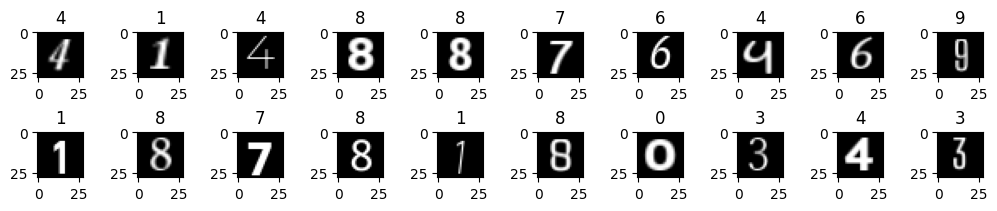

In [4]:
def view(digits, labels, rows=1, cols=10, title=None):
    fig, subs = plt.subplots(rows, cols, layout='constrained', figsize=(cols,rows + (0.25 if title else 0)), squeeze=False)
    if title:
        fig.suptitle(title)
    subs = [s for sub in subs for s in sub] 
    for digit, label, sub in zip(digits, labels, subs):
        sub.set_title(label)
        sub.imshow(digit, cmap='gray')

samples = np.random.choice(len(digits), 20)

view(digits[samples], labels[samples], rows=2)

2024-06-09 10:27:30.091522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 10:27:30.096190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 10:27:30.096254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 10:27:30.099257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 10:27:30.099317: I external/local_xla/xla/stream_executor

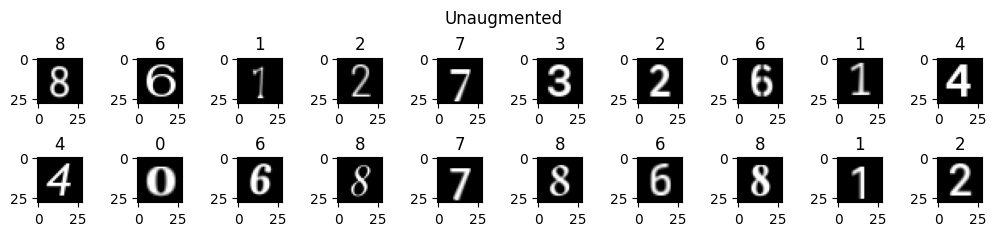

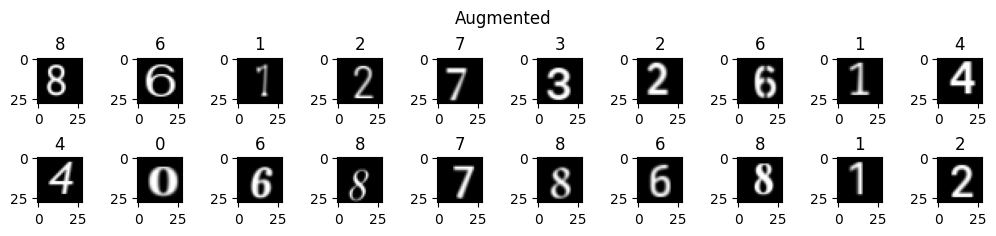

In [5]:
# As with digit recognition, it's only really the translations that are relevant (I add the 90/180/270 deg rotations later)
augmentations = keras.Sequential([
    # layers.RandomRotation(0.05),
    # layers.RandomZoom((-0.2, 0), (-0.2, 0), fill_mode="constant", fill_value=0),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), fill_mode="constant", fill_value=0),
])

samples = np.random.choice(len(digits), 20)

augmented_digits = augmentations(digits[samples])

view(digits[samples], labels[samples], title="Unaugmented", rows=2)
view(augmented_digits, labels[samples], title="Augmented", rows=2)

In [6]:
# As a n00b I have no idea how to do this not in memory...
x = np.concatenate([digits] + [augmentations(digits) for _ in range(4)])

p = np.random.permutation(len(x))
x = x[p]

print("Digits after augmentation:", len(x))

Digits after augmentation: 149500


Digits with rotations: 598000


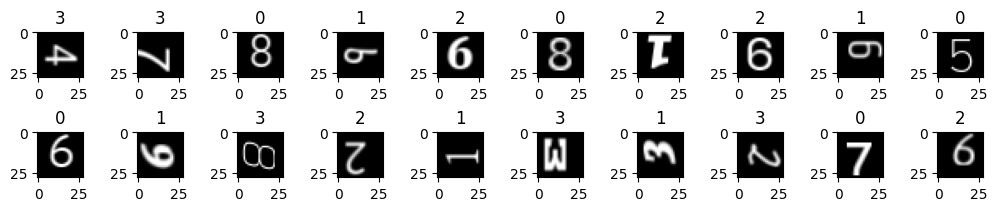

In [7]:
def add_orientations(x):
    length = len(x)
    x = np.concatenate([
        np.array([np.rot90(d, k=i) for d in x])
        for i in range(4)
    ])
    y = np.concatenate([np.full((length,), i) for i in range(4)])

    assert len(x) == len(y)
    
    p = np.random.permutation(len(x))
    return x[p], y[p]

x, y = add_orientations(x)

samples = np.random.choice(len(digits), 20)

print("Digits with rotations:", len(x))
view(x[samples], y[samples], rows=2)

In [8]:
TRAINING_SET = 0.8
r = np.random.default_rng(seed=12345)
training_mask = np.fromiter((r.random() <= TRAINING_SET for _ in range(len(x))), dtype=bool)

x_train = x[training_mask]
x_test = x[~training_mask]

y_train = keras.utils.to_categorical(y[training_mask], 4)
y_test = keras.utils.to_categorical(y[~training_mask], 4)

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 478524
Test samples: 119476


In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        # layers.Dropout(0.5),
        # layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         6,404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,220 (98.52 KB)

 Trainable params: 25,220 (98.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
batch_size = 10000
# Something about "early exit" to help optimise the count of epoch?
epochs = 200

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/200


I0000 00:00:1717928902.789920     391 service.cc:145] XLA service 0x8801a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717928902.791961     391 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-09 10:28:22.890715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 10:28:23.310261: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 4/44 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3388 - loss: 1.3517

I0000 00:00:1717928911.021856     391 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.5233 - loss: 1.0609 - val_accuracy: 0.7520 - val_loss: 0.5878
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7406 - loss: 0.5886 - val_accuracy: 0.8122 - val_loss: 0.4625
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7903 - loss: 0.4877 - val_accuracy: 0.8354 - val_loss: 0.4106
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8118 - loss: 0.4420 - val_accuracy: 0.8446 - val_loss: 0.3822
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8221 - loss: 0.4139 - val_accuracy: 0.8521 - val_loss: 0.3617
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8289 - loss: 0.3959 - val_accuracy: 0.8568 - val_loss: 0.3468
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8347 - loss: 0.3808 - val_accuracy: 0.8580 - val_loss: 0.3397
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8386 - loss: 0.3719 - val_accuracy: 0.8649 - val

2024-06-09 10:32:17.745374: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31520000 bytes after encountering the first element of size 31520000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8837 - loss: 0.2509 - val_accuracy: 0.8967 - val_loss: 0.2232
Epoch 120/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8852 - loss: 0.2500 - val_accuracy: 0.8939 - val_loss: 0.2260
Epoch 121/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8820 - loss: 0.2536 - val_accuracy: 0.8958 - val_loss: 0.2235
Epoch 122/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8832 - loss: 0.2519 - val_accuracy: 0.8967 - val_loss: 0.2217
Epoch 123/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8839 - loss: 0.2498 - val_accuracy: 0.8971 - val_loss: 0.2215
Epoch 124/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8841 - loss: 0.2511 - val_accuracy: 0.8967 - val_loss: 0.2210
Epoch 125/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8847 - loss: 0.2493 - val_accuracy: 0.8975 - val_loss: 0.2204
Epoch 126/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8838 - loss: 0.2515 - val_accuracy: 

2024-06-09 10:34:51.622959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31520000 bytes after encountering the first element of size 31520000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8893 - loss: 0.2378 - val_accuracy: 0.8994 - val_loss: 0.2103
Epoch 200/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8890 - loss: 0.2364 - val_accuracy: 0.9005 - val_loss: 0.2101


3734/3734 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9016 - loss: 0.2104
Test loss: 0.21169447898864746
Test accuracy: 0.9005741477012634


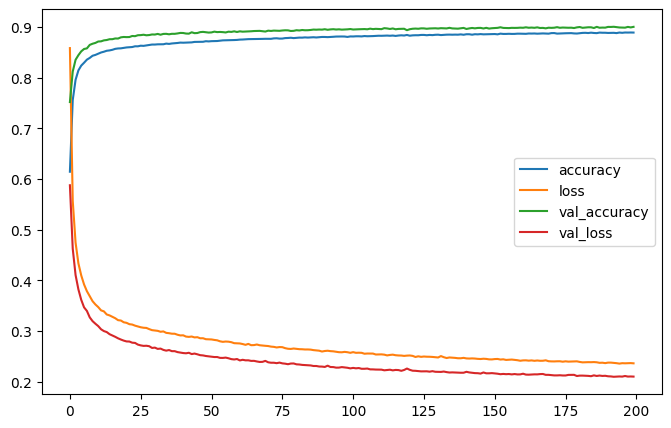

In [11]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [12]:
import time
model.save(f"models/orientations_{int(score[1] * 10000)}_{int(score[0] * 10000):04}_{int(time.time())}.keras")